### Senior Vehicle Ownership in the City of Los Angeles
<b>Author:</b> Monisha Reginald<br><br>
<b>Purpose:</b> This week, I explored data on vehicle ownership for senior-headed households to understand 1) how senior vehicle ownership compares to vehicle ownership for all households, 2) which areas have the lowest rates of vehicle ownership.<br>
<b>Findings:</b> Senior vehicle ownership generally trends with general vehicle ownership, but seniors are less likely to own vehicles in all areas of Los Angeles. Seniors are the least likely to own a vehicle in the densest part of Los Angeles (Central LA and South LA), but this is an area that benefits from a comparatively high density of grocery stores and transit. However, there is also substantial lack of vehicle access in the area of the San Fernando Valley between North Hollywood and Van Nuys - this may be an interesting area to explore due to the comparatively high presence of vehicle-free households and comparatively low-density built environment.

In [1]:
# Import libraries.
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import scipy as spy

We use the Census API to pull in demographic data related to household vehicle ownership by age for all block groups in LA County. We only want block groups in City of LA, but that isn't a supported geographical heirarchy, so we'll have to pull in a larger set and filter later on.

In [2]:
import requests
apirequest = 'https://api.census.gov/data/2021/acs/acs5?get=NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E&for=block%20group:*&in=state:06%20county:037'
usr_key = f"&key=4c422219a890d0597a042d9ebad9311b022cfd4d"
#Put it all together in one f-string:
query_url = f"{apirequest}{usr_key}"
# Use requests package to call out to the API
response = requests.get(query_url)

We have to convert this API response to a dataframe that we can work with in Python.

In [3]:
# We have to create a dataframe from the original response converted to json.
census_df=pd.DataFrame(response.json())

# Now we can take a look at the data in Python.
census_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E,state,county,tract,block group
1,"Block Group 1, Census Tract 1011.10, Los Angel...",40,0,299,53,44,0,212,60,06,037,101110,1
2,"Block Group 2, Census Tract 1011.10, Los Angel...",28,28,236,90,62,42,234,53,06,037,101110,2
3,"Block Group 3, Census Tract 1011.10, Los Angel...",0,0,247,74,18,18,74,0,06,037,101110,3
4,"Block Group 1, Census Tract 1011.22, Los Angel...",9,0,593,223,0,0,184,0,06,037,101122,1


We notice that the variable names are in the first row of the dataframe, so we move the variable names from row 0 to the column headers.

In [4]:
# Rename columns with data in row 0.
census_df.columns = census_df.iloc[0]

# Now drop row 0 now that column names have been successfully extracted.
census_df = census_df.iloc[1:]

# Check that column names have been updated.
census_df.head()

,NAME,B25045_003E,B25045_006E,B25045_007E,B25045_010E,B25045_012E,B25045_015E,B25045_016E,B25045_019E,state,county,tract,block group
1,"Block Group 1, Census Tract 1011.10, Los Angel...",40,0,299,53,44,0,212,60,06,037,101110,1
2,"Block Group 2, Census Tract 1011.10, Los Angel...",28,28,236,90,62,42,234,53,06,037,101110,2
3,"Block Group 3, Census Tract 1011.10, Los Angel...",0,0,247,74,18,18,74,0,06,037,101110,3
4,"Block Group 1, Census Tract 1011.22, Los Angel...",9,0,593,223,0,0,184,0,06,037,101122,1
5,"Block Group 2, Census Tract 1011.22, Los Angel...",0,0,426,136,0,0,160,0,06,037,101122,2


We will now alter our dataset so that it contains just columns that we need and those columns have clear labels.

In [5]:
# Rename Census variable names and drop unnessaray variables.
census_df=census_df.rename(columns={'B25045_003E':'Owner no vehicle', 'B25045_006E':'Owner no vehicle 65+',
                         'B25045_007E':'Owner with vehicle', 'B25045_010E' : 'Owner with vehicle 65+',
                         'B25045_012E' : 'Renter no vehicle', 'B25045_015E' : 'Renter no vehicle 65+',
                         'B25045_016E' : 'Renter with vehicle', 'B25045_019E' : 'Renter with vehicle 65+'},).drop(columns=['NAME','state','county'])

# Check that this worked. 
census_df.head()

,Owner no vehicle,Owner no vehicle 65+,Owner with vehicle,Owner with vehicle 65+,Renter no vehicle,Renter no vehicle 65+,Renter with vehicle,Renter with vehicle 65+,tract,block group
1,40,0,299,53,44,0,212,60,101110,1
2,28,28,236,90,62,42,234,53,101110,2
3,0,0,247,74,18,18,74,0,101110,3
4,9,0,593,223,0,0,184,0,101122,1
5,0,0,426,136,0,0,160,0,101122,2


Before we begin to map and analyze this data, we have to associate it with the block groups' geometries and then cut the dataframe down from the entire Los Angeles County to Los Angeles City.

In [6]:
# Import block group geometries, but get rid of columns we're not interested in.
bg_proj = gpd.read_file("Census_Block_Groups_2020.geojson").drop(columns=['OBJECTID','CT20','LABEL','ShapeSTLength',]).to_crs('epsg:6423')

# Inspect rows.
bg_proj.head()

,BG20,ShapeSTArea,geometry
0,1011101,4.814335e+06,"POLYGON ((1973753.403 583983.323, 1973753.719 ..."
1,1011102,3.814445e+06,"POLYGON ((1973047.145 584294.384, 1972997.597 ..."
2,1011103,3.666841e+06,"POLYGON ((1973168.253 584293.145, 1973168.145 ..."
3,1011221,1.711345e+07,"POLYGON ((1973282.068 585913.511, 1973282.231 ..."
4,1011222,1.134430e+07,"POLYGON ((1973727.891 585054.579, 1973716.317 ..."


To be able to join these datasets together, I will create an appropriate key in my census data by concatenating the census tract and block group numbers to create a unique identified (BG20) that matches the block group geographies.

In [7]:
# Concatenate tract and block group numbers.
census_df['BG20']=census_df['tract']+census_df['block group']

# Drop the separated tract and block group columns, which are no longer necessary.
census_df=census_df.drop(columns=['tract','block group'])
census_df.head()

,Owner no vehicle,Owner no vehicle 65+,Owner with vehicle,Owner with vehicle 65+,Renter no vehicle,Renter no vehicle 65+,Renter with vehicle,Renter with vehicle 65+,BG20
1,40,0,299,53,44,0,212,60,1011101
2,28,28,236,90,62,42,234,53,1011102
3,0,0,247,74,18,18,74,0,1011103
4,9,0,593,223,0,0,184,0,1011221
5,0,0,426,136,0,0,160,0,1011222


We join the census data to the block group geometries, so that each block group has the appropriate spatial and demographic data.

In [8]:
# Left join census_clean data onto the block group geometries.
census_bg=pd.merge(bg_proj, census_df, how="left", on=["BG20"])
census_bg.head()

,BG20,ShapeSTArea,geometry,Owner no vehicle,Owner no vehicle 65+,Owner with vehicle,Owner with vehicle 65+,Renter no vehicle,Renter no vehicle 65+,Renter with vehicle,Renter with vehicle 65+
0,1011101,4.814335e+06,"POLYGON ((1973753.403 583983.323, 1973753.719 ...",40,0,299,53,44,0,212,60
1,1011102,3.814445e+06,"POLYGON ((1973047.145 584294.384, 1972997.597 ...",28,28,236,90,62,42,234,53
2,1011103,3.666841e+06,"POLYGON ((1973168.253 584293.145, 1973168.145 ...",0,0,247,74,18,18,74,0
3,1011221,1.711345e+07,"POLYGON ((1973282.068 585913.511, 1973282.231 ...",9,0,593,223,0,0,184,0
4,1011222,1.134430e+07,"POLYGON ((1973727.891 585054.579, 1973716.317 ...",0,0,426,136,0,0,160,0


The next step is to cut this down to just the block groups within the City of Los Angeles.

<AxesSubplot: >

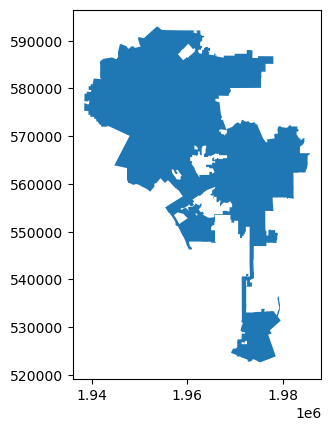

In [9]:
# Import LA City boundary directly from Los Angeles GeoHub. 
cityboundary_proj=gpd.read_file("https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/7/query?outFields=*&where=1%3D1&f=geojson").to_crs('epsg:6423')
cityboundary_proj.plot()

We will "clip" the block group geodataframe to the LA City boundary. However, the block group boundaries do not always align well with the LA city boundary. Because the "clip" function will return all block groups that have any part within the municipal boundary, we will drop all block groups that have less than 6% of their original area in their clipped forms.

In [10]:
# Calculate area of original block group geometries.
census_bg['bg_area']=(census_bg.area)*.0001

# Clip the block group data to the LA city boundary to get just block groups within the City of LA.
census_la=gpd.clip(census_bg, cityboundary_proj)

# Calculate area of new block group geometries.
census_la['area']=(census_la.area)*.0001

# Keep only rows where the area of the new geometry covers at least 6% of the original block group's geometry.
census_la=census_la.loc[(census_la['area']/census_la['bg_area']) > 0.06]

# Drop these columns now that we don't need them anymore!
census_la=census_la.drop(columns=['bg_area','area'])

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


We now have a geodataframe that contains just the block groups within Los Angeles and contains all of the spatial and demographic data needed for some analysis. Now we can begin analysis! This ACS data table contains data on household vehicle ownership by tenure by age, and we want data on just household vehicle ownership by age, so we'll have to sum up the existing columns to get the columns that we're interested in. 

In [11]:
# Cast numeric data that was originally imported as a string as an integers so they can be used in calculations.
census_clean=census_la.astype({'Owner no vehicle':'int', 'Owner no vehicle 65+':'int', 'Owner with vehicle':'int', 'Owner with vehicle 65+': 'int', 
                                  'Renter no vehicle':'int', 'Renter no vehicle 65+' : 'int', 'Renter with vehicle' : 'int' , 'Renter with vehicle 65+' : 'int'})

# Calculate necesarry sums.
census_clean['Total HH']=census_clean['Owner no vehicle']+census_clean['Owner with vehicle']+census_clean['Renter no vehicle']+census_clean['Renter with vehicle']
census_clean['Senior HH']=census_clean['Owner no vehicle 65+']+census_clean['Owner with vehicle 65+']+census_clean['Renter no vehicle 65+']+census_clean['Renter with vehicle 65+']
census_clean['Total No Vehicle']=census_clean['Owner no vehicle']+census_clean['Renter no vehicle']
census_clean['Senior No Vehicle']=census_clean['Owner no vehicle 65+']+census_clean['Renter no vehicle 65+']

# Drop columns I don't need anymore now that calculations are done.
census_clean=census_clean.drop(columns=['Owner no vehicle', 'Owner no vehicle 65+', 'Owner with vehicle', 'Owner with vehicle 65+', 
                                        'Renter no vehicle', 'Renter no vehicle 65+', 'Renter with vehicle', 'Renter with vehicle 65+'])

# Check that this worked.
census_clean.head()

,BG20,ShapeSTArea,geometry,Total HH,Senior HH,Total No Vehicle,Senior No Vehicle
2457,2742024,1.025353e+06,"POLYGON ((1957411.652 552704.523, 1957421.647 ...",478,86,64,0
2456,2742023,1.045276e+06,"POLYGON ((1957062.422 552945.617, 1957021.289 ...",569,13,0,0
2449,2739025,5.131686e+06,"POLYGON ((1956444.116 553818.366, 1956472.024 ...",496,146,31,31
2448,2739024,1.861628e+06,"POLYGON ((1956970.245 553315.644, 1956950.061 ...",411,57,0,0
2447,2739023,1.218168e+06,"POLYGON ((1957205.091 554025.253, 1957209.466 ...",528,119,16,0


Now we'll calculate percentages with our calculated sums.

In [12]:
# Calculate percentages.
census_clean['Pct Households Without a Vehicle'] = census_clean['Total No Vehicle']/census_clean['Total HH']*100
census_clean['Pct Senior-Headed Households Without a Vehicle']= census_clean['Senior No Vehicle']/census_clean['Senior HH']*100

# Check that this worked.
census_clean.head()

,BG20,ShapeSTArea,geometry,Total HH,Senior HH,Total No Vehicle,Senior No Vehicle,Pct Households Without a Vehicle,Pct Senior-Headed Households Without a Vehicle
2457,2742024,1.025353e+06,"POLYGON ((1957411.652 552704.523, 1957421.647 ...",478,86,64,0,13.389121,0.000000
2456,2742023,1.045276e+06,"POLYGON ((1957062.422 552945.617, 1957021.289 ...",569,13,0,0,0.000000,0.000000
2449,2739025,5.131686e+06,"POLYGON ((1956444.116 553818.366, 1956472.024 ...",496,146,31,31,6.250000,21.232877
2448,2739024,1.861628e+06,"POLYGON ((1956970.245 553315.644, 1956950.061 ...",411,57,0,0,0.000000,0.000000
2447,2739023,1.218168e+06,"POLYGON ((1957205.091 554025.253, 1957209.466 ...",528,119,16,0,3.030303,0.000000


We are interested in vehicle ownership rates for the City of LA as a whole to contexualize the percentages for individual block groups, so we will calcualte stats across the block groups.

In [13]:
# Calculate sum across all block groups (results in a series) and then convert that series to a transposed dataframe.
city_totals=census_clean.sum(numeric_only=True).to_frame().transpose()

# Recalculate percentages.
city_totals['Pct Households Without a Vehicle']=(city_totals['Total No Vehicle']/city_totals['Total HH'])*100
city_totals['Pct Senior-Headed Households Without a Vehicle']=(city_totals['Senior No Vehicle']/city_totals['Senior HH'])*100

# Check that things look right.
city_totals

,ShapeSTArea,Total HH,Senior HH,Total No Vehicle,Senior No Vehicle,Pct Households Without a Vehicle,Pct Senior-Headed Households Without a Vehicle
0,1.352925e+10,1385427.0,287185.0,161724.0,58193.0,11.673224,20.263245


Finally, I'm interested in aggregating this data by neighborhood. To do this, I'm going to join this data to a neighborhood boundary geodataframe.

In [14]:
# Import geojson directly from LA GeoHub.
neighborhoods=gpd.read_file('https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423')

# Rename 'name' column so that it is still meaningful out of context.
neighborhoods=neighborhoods.rename(columns={'name' : 'neighborhood'})

I'm going to create a new geodataframe that assigns each census block group to the neighborhood that contains the largest portion of its area.

In [15]:
# Get intersection of each block group and neighborhood and then calculate the area of each of these intersections.
census_neighborhoods=gpd.overlay(census_clean, neighborhoods, how='intersection', keep_geom_type=False)
census_neighborhoods['area']=census_neighborhoods.area

# For each block group, keep just the row that has the largest area (intersection with neighborhood that contains largest portion of its area)
census_neighborhoods=census_neighborhoods.sort_values(by=['BG20','area'],ascending=False).reset_index().drop_duplicates(subset=['BG20'], keep='first').drop(columns=['geometry','area'])

# Give the census block groups their original geographies back.
census_neighborhoods=pd.merge(census_neighborhoods,(census_la[['BG20','geometry']]),how='left',on=['BG20']).set_geometry('geometry')

Now, we will create a new dataset that groups this data by neighborhood.

In [16]:
# Create a new dataframe with totals for each neighborhood that sums up all relevant columns.
neighborhood_sums = census_neighborhoods.groupby(['neighborhood']).sum(numeric_only=True).reset_index()

# Recalculate percentages.
neighborhood_sums['Pct Households Without a Vehicle']=(neighborhood_sums['Total No Vehicle']/neighborhood_sums['Total HH'])*100
neighborhood_sums['Pct Senior-Headed Households Without a Vehicle']=(neighborhood_sums['Senior No Vehicle']/neighborhood_sums['Senior HH'])*100

# Finally, we have to add back in the geometry column from the original neighborhood geodataframe.
neighborhood_sums=pd.merge(neighborhoods,neighborhood_sums,how="left", on=['neighborhood']).drop(columns=['OBJECTID_y']).rename(columns={'OBJECTID_x' : 'OBJECTID'})

# See how this table looks.
neighborhood_sums.head()

,OBJECTID,neighborhood,geometry,index,ShapeSTArea,Total HH,Senior HH,Total No Vehicle,Senior No Vehicle,Pct Households Without a Vehicle,Pct Senior-Headed Households Without a Vehicle
0,1,Adams-Normandie,"POLYGON ((1972233.388 559643.685, 1971938.035 ...",20899,2.190725e+07,5141,915,960,294,18.673410,32.131148
1,2,Arleta,"POLYGON ((1959244.309 584850.051, 1959257.540 ...",81508,8.494875e+07,7950,1791,337,164,4.238994,9.156896
2,3,Arlington Heights,"POLYGON ((1970582.552 561395.372, 1970757.410 ...",7048,2.592892e+07,6220,1151,940,256,15.112540,22.241529
3,4,Atwater Village,"MULTIPOLYGON (((1974284.934 572493.221, 197428...",23031,4.378378e+07,4782,1207,279,126,5.834379,10.439105
4,5,Baldwin Hills/Crenshaw,"POLYGON ((1966656.952 558331.179, 1966727.113 ...",7407,7.776117e+07,14391,3609,2323,835,16.142033,23.136603


### Charts
We now have the data that we need to begin making some charts!

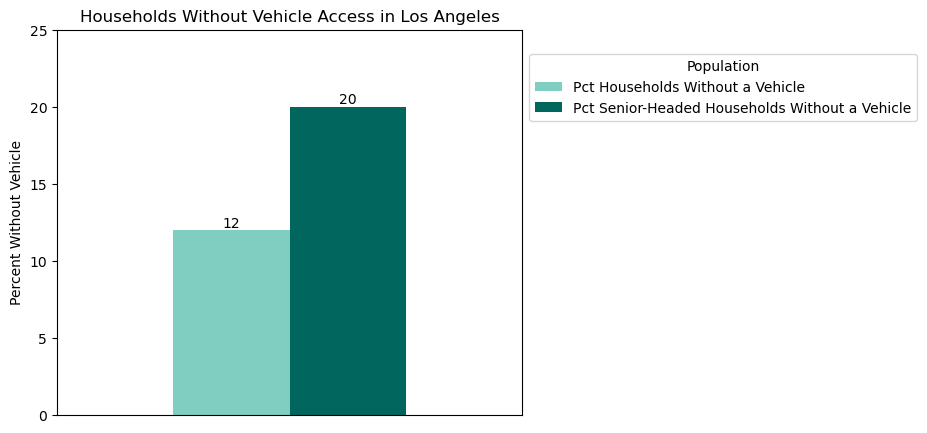

In [17]:
# Create a dataframe for chart with just rounded percentages.
city_bar=city_totals[['Pct Households Without a Vehicle', 'Pct Senior-Headed Households Without a Vehicle']].round()

fig, ax = plt.subplots(figsize=(6,5))

#Create bar plot and label the two bars with their values.
ax = city_bar.plot(ax=ax, kind='bar', color=['#80cdc1','#01665e'], legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

# Adjust x-axis so it doesn't have a subtitle or ticks.
plt.xlabel(None)
ax.set_xticks([])

# Ajust y-axis so that it has desired subtitle and ticks.
plt.ylabel("Percent Without Vehicle")
ax.set_yticks((0,5,10,15,20,25))

#Adjust table and legend.
plt.title("Households Without Vehicle Access in Los Angeles")
plt.legend(loc='center left', bbox_to_anchor=(1, .85), title='Population')

plt.show()

Now some scatter plots to further understand the relationship between vehicle access and senior vehicle access.

Text(0.5, 1.0, 'Household Vehicle Access at Block Group Level')

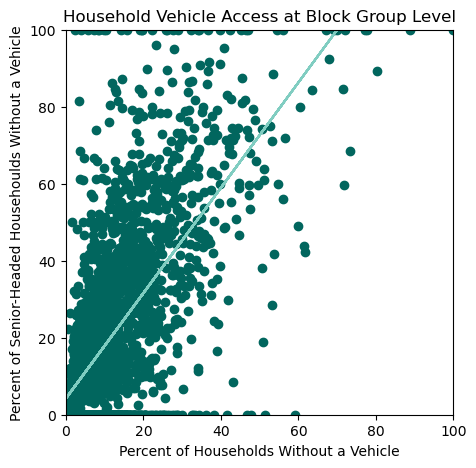

In [18]:
# Create filtered version that exclused all rows with missing data
census_linear=census_clean[(census_clean["Pct Households Without a Vehicle"]>=0) & (census_clean["Pct Senior-Headed Households Without a Vehicle"]>=0)]

# Calculate line of best fit for this filtered dataframe.
m, b = np.polyfit(census_linear["Pct Households Without a Vehicle"], census_linear["Pct Senior-Headed Households Without a Vehicle"], 1)

# Start plot
fig,ax = plt.subplots(figsize=(5,5))

# Plot all points and line of best fit.
ax = plt.plot(census_clean["Pct Households Without a Vehicle"], census_clean["Pct Senior-Headed Households Without a Vehicle"], 'o', color='#01665e')
ax = plt.plot(census_clean["Pct Households Without a Vehicle"], m*census_clean["Pct Households Without a Vehicle"] + b, color='#80cdc1')

plt.xlim(0,100)
plt.xlabel("Percent of Households Without a Vehicle")

plt.ylim(0,100)
plt.ylabel("Percent of Senior-Headed Househoulds Without a Vehicle")

plt.title("Household Vehicle Access at Block Group Level")

That's too many, so I'll do the same thing with one dot per neighborhood.

Text(0.5, 1.0, 'Household Vehicle Access at Neighborhood Level')

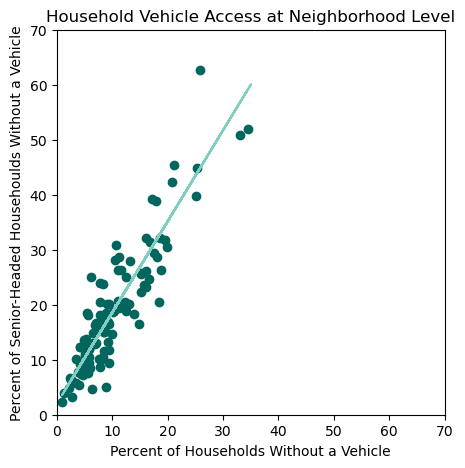

In [19]:
neighborhood_linear=neighborhood_sums[(neighborhood_sums["Pct Households Without a Vehicle"]>=0) &
                                      (neighborhood_sums["Pct Senior-Headed Households Without a Vehicle"]>=0)]

# Create line of best fit.
m, b = np.polyfit(neighborhood_linear["Pct Households Without a Vehicle"], neighborhood_linear["Pct Senior-Headed Households Without a Vehicle"], 1)

fig,ax = plt.subplots(figsize=(5,5))

# Plot scatter plot and line of best fit.
ax = plt.plot(neighborhood_linear["Pct Households Without a Vehicle"], neighborhood_linear["Pct Senior-Headed Households Without a Vehicle"],
              'o', color='#01665e')
ax = plt.plot(neighborhood_linear["Pct Households Without a Vehicle"], m*neighborhood_linear["Pct Households Without a Vehicle"] + b,
             color='#80cdc1')

plt.xlim(0,70)
plt.xlabel("Percent of Households Without a Vehicle")

plt.ylim(0,70)
plt.ylabel("Percent of Senior-Headed Househoulds Without a Vehicle")

plt.title("Household Vehicle Access at Neighborhood Level")

### Maps
Next, we want to create maps that show where seniors are the least likely to own a car and compares this to the places that people (regardless of age) are the least likely to own a car.

We'll create a new version of this dataframe that replaces "N/A" values (which result when there are either no people or no seniors within a block group) with 0s, so that they are visually grouped with other areas where there is less need to invest in transit infrastructure.

In [20]:
# Create a new dataframe for mapping purposes.
census_map=census_clean

# Set value of 0 on rows where the percentages are currently "N/A"
census_map['Pct Households Without a Vehicle'] = census_map['Pct Households Without a Vehicle'].fillna(0)
census_map['Pct Senior-Headed Households Without a Vehicle'] = census_map['Pct Senior-Headed Households Without a Vehicle'].fillna(0)

Finally, Dom suggested that we include the locations of senior housing buildings, so I'm going to do that!

In [21]:
seniorhousing=gpd.read_file("https://services1.arcgis.com/tp9wqSVX1AitKgjd/arcgis/rest/services/Senior_Housing/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson").to_crs('epsg:6423')

We want to map the block groups pased on their senior vehicle-ownership percentile, so we'll categorize them based on their percentile.

In [22]:
# First we have to sort and re-index this dataframe so the row number corresponds to its rank.
census_smap=census_map.sort_values('Pct Senior-Headed Households Without a Vehicle').reset_index()

# Categorize rows according to their row percentile
census_smap['Senior_Category']= '1: Below Average'
census_smap.loc[census_smap['Pct Senior-Headed Households Without a Vehicle'] >
               (census_smap.loc[round(len(census_smap)*(.40)),'Pct Senior-Headed Households Without a Vehicle']), 'Senior_Category'] = "2: Average"
census_smap.loc[census_smap['Pct Senior-Headed Households Without a Vehicle'] >
               (census_smap.loc[round(len(census_smap)*(.60)),'Pct Senior-Headed Households Without a Vehicle']), 'Senior_Category'] = "3: Above Average"

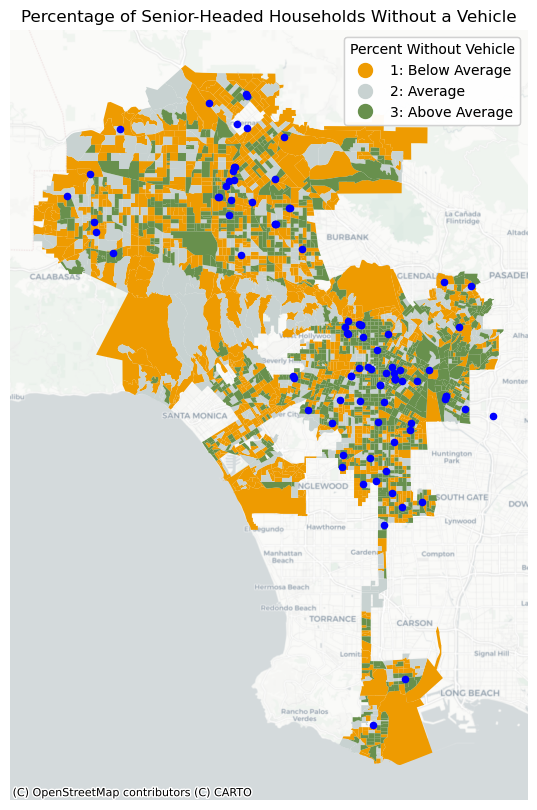

In [23]:
# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'1: Below Average' : '#EE9B01', '2: Average': '#C8D2D1', '3: Above Average': '#68904D'}

census_smap["colors"] = census_smap["Senior_Category"].map(color_dict)

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(10,10))
ax = census_smap.plot(ax=ax, color=census_smap["colors"])
ax= seniorhousing.plot(ax=ax, color='blue', markersize=20)


# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(), title="Percent Without Vehicle")
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
ax.set_title('Percentage of Senior-Headed Households Without a Vehicle')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

That's a lot to deal with, so I'll try this process for neighborhoods. 

In [24]:
# First we have to sort and re-index this dataframe so the row number corresponds to its rank.
neighborhood_sorted=neighborhood_sums.sort_values('Pct Senior-Headed Households Without a Vehicle').reset_index()

# Categorize rows according to their row percentile
neighborhood_sorted['Senior_Category']= '1: Below Average'
neighborhood_sorted.loc[neighborhood_sorted['Pct Senior-Headed Households Without a Vehicle'] >
               (neighborhood_sorted.loc[round(len(neighborhood_sorted)*(.40)),'Pct Senior-Headed Households Without a Vehicle']), 'Senior_Category'] = "2: Average"
neighborhood_sorted.loc[neighborhood_sorted['Pct Senior-Headed Households Without a Vehicle'] >
               (neighborhood_sorted.loc[round(len(neighborhood_sorted)*(.60)),'Pct Senior-Headed Households Without a Vehicle']), 'Senior_Category'] = "3: Above Average"

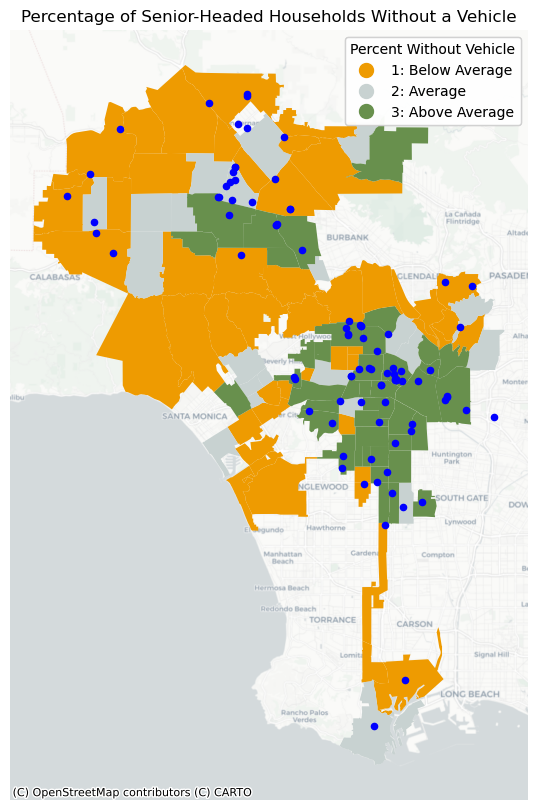

In [25]:
# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'1: Below Average' : '#EE9B01', '2: Average': '#C8D2D1', '3: Above Average': '#68904D'}

neighborhood_sorted["colors"] = neighborhood_sorted["Senior_Category"].map(color_dict)

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(10,10))
ax = neighborhood_sorted.plot(ax=ax, color=neighborhood_sorted["colors"])
ax= seniorhousing.plot(ax=ax, color='blue', markersize=20)

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(), title="Percent Without Vehicle")
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
ax.set_title('Percentage of Senior-Headed Households Without a Vehicle')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

<b>RECOMMENDATION</b>: The North Hollywood, Valley Glen, Van Nuys, Panorama City area of the San Fernando Valley is the best place to focus due to the comparatively higher rates of vehicle-free households, which is unusual for an area outside of the Central and South LA regions.